### Punto 2 Algoritmo Genético

In [16]:
import heapq
import math
import time
import random
from collections import deque
import sys
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

sys.path.append("..")
from Graph import Graph

In [17]:
# Gráfico de Medellín con distancias entre nodos
GRAPH = {
    "Robledo":       [("Laureles", 3.0), ("Doce de Octubre", 2.5), ("San Cristóbal", 4.0)],
    "Doce de Octubre": [("Robledo", 2.5), ("Castilla", 1.8)],
    "Castilla":      [("Doce de Octubre", 1.8), ("Tricentenario", 1.2)],
    "Tricentenario": [("Castilla", 1.2), ("Aranjuez", 1.5), ("Prado", 2.0)],
    "Aranjuez":      [("Tricentenario", 1.5), ("Buenos Aires", 3.5)],
    "Prado":         [("Tricentenario", 2.0), ("Centro", 1.2)],
    "Centro":        [("Prado", 1.2), ("Laureles", 2.5), ("Buenos Aires", 2.0), ("El Poblado", 4.0)],
    "Buenos Aires":  [("Centro", 2.0), ("Aranjuez", 3.5), ("San Diego", 1.5)],
    "San Diego":     [("Buenos Aires", 1.5), ("El Poblado", 2.0)],
    "Laureles":      [("Robledo", 3.0), ("Centro", 2.5), ("Belén", 2.0), ("Estadio", 1.0)],
    "Estadio":       [("Laureles", 1.0), ("El Poblado", 4.5)],
    "Belén":         [("Laureles", 2.0), ("El Poblado", 3.0)],
    "El Poblado":    [("Belén", 3.0), ("Estadio", 4.5), ("Centro", 4.0), ("San Diego", 2.0)],
    "San Cristóbal": [("Robledo", 4.0)]
}

In [18]:
# Coordenadas aproximadas (solo para heurística y posición relativa)
COORDS = {
    "San Cristóbal": (0.0, 5.0),
    "Robledo": (2.0, 5.0),
    "Doce de Octubre": (3.5, 6.5),
    "Castilla": (5.0, 6.0),
    "Tricentenario": (6.0, 5.0),
    "Aranjuez": (8.0, 6.0),
    "Prado": (7.0, 4.0),
    "Centro": (8.0, 3.0),
    "Buenos Aires": (10.0, 4.0),
    "San Diego": (11.0, 3.0),
    "Laureles": (4.0, 4.0),
    "Estadio": (5.0, 3.0),
    "Belén": (3.0, 3.0),
    "El Poblado": (9.0, 1.0)
}

In [19]:
# Heurística de distancia euclidiana
def euclidean_heuristic(node_a, node_b, coords=COORDS):
    """Distancia euclidiana entre node_a y node_b (en mismas unidades que coords)."""
    (x1, y1) = coords[node_a]
    (x2, y2) = coords[node_b]
    return math.hypot(x1 - x2, y1 - y2)

In [20]:
# Algoritmo de A*, utilizado en algoritmo genético para calcular las distancias mínimas entre dos puntos
def a_star(graph, start, goal, heuristic=euclidean_heuristic, verbose=False):
    """
    Ejecuta A* sobre `graph` desde `start` hasta `goal`.
    - graph: dict nodo -> list of (vecino, costo)
    - heuristic: funcion(node, goal) -> float
    - verbose: si True imprime paso a paso la exploración y frontier
    Retorna: dict con keys: path (lista), cost_total, nodes_expanded, explored_sequence, time_s
    """
    t0 = time.perf_counter()
    # frontier: heap de tuplas (f, contador, nodo)
    frontier = []
    counter = 0
    g_score = {start: 0.0}        # costo desde start hasta el nodo
    f_start = heuristic(start, goal)
    heapq.heappush(frontier, (f_start, counter, start))
    parent = {start: None}
    explored = set()
    explored_sequence = []

    while frontier:
        f_current, _, current = heapq.heappop(frontier)

        # Si ya expandimos lo ignoramos (pueden haber entradas antiguas en el heap)
        if current in explored:
            continue

        explored.add(current)
        explored_sequence.append(current)

        if verbose:
            print(f"> Pop nodo: {current}  (f={f_current:.3f}, g={g_score.get(current, float('inf')):.3f}, h={f_current - g_score.get(current,0):.3f})")
            # Mostrar frontier actual (no ordenado)
            frontier_snapshot = [(item[2], item[0]) for item in frontier]
            print("  Frontier (nodo, f):", frontier_snapshot)

        if current == goal:
            # reconstruir camino
            path = []
            node = goal
            while node is not None:
                path.append(node)
                node = parent[node]
            path.reverse()
            t1 = time.perf_counter()
            return {
                "path": path,
                "cost_total": g_score[goal],
                "nodes_expanded": len(explored),
                "explored_sequence": explored_sequence,
                "time_s": t1 - t0
            }

        # Expandir vecinos
        for neighbor, cost in graph.get(current, []):
            tentative_g = g_score[current] + cost
            # Si no tiene g_score conocido o encontramos uno mejor
            if neighbor not in g_score or tentative_g < g_score[neighbor]:
                g_score[neighbor] = tentative_g
                parent[neighbor] = current
                h = heuristic(neighbor, goal)
                f_new = tentative_g + h
                counter += 1
                heapq.heappush(frontier, (f_new, counter, neighbor))
                if verbose:
                    print(f"    -> Considerando vecino: {neighbor}  (costo={cost:.2f})  tentative_g={tentative_g:.3f}  h={h:.3f}  f={f_new:.3f}")
    # Si se vació frontier y no encontramos goal
    t1 = time.perf_counter()
    return {
        "path": None,
        "cost_total": None,
        "nodes_expanded": len(explored),
        "explored_sequence": explored_sequence,
        "time_s": t1 - t0
    }

In [21]:
# Construir matriz de distancias entre nodos
# Retorna distancias, el camino completo entre dos nodos, y mapa de indices para preservar el orden
def build_distance_matrix(graph, goals):
    distances = [[float("inf") for goal in goals] for goal in goals]
    idx_map = {goal: i for i, goal in enumerate(goals)}
    paths = {}

    for i in range(len(goals)):
        for j in range(len(goals)):
            if i == j:
                distances[i][j] = 0.0
            else:
                search = a_star(graph, goals[i], goals[j], heuristic=euclidean_heuristic)
                distances[i][j] = search["cost_total"]
                paths[(goals[i], goals[j])] = search["path"]
    return distances, paths, idx_map

In [22]:
# Generar población de individuos, representando el orden de visita a los nodos
def generate_population(n, goals):
    population = []
    for i in range(n):
        individual = goals[:]
        random.shuffle(individual)
        population.append(individual)
    return population

In [23]:
# Calcular la aptitud del individuo por medio de la matriz de distancias
def fitness(individual, idx_map, distances):
    travel_cost = 0
    for i in range(len(individual) - 1):
        travel_cost += distances[idx_map[individual[i]]][idx_map[individual[i+1]]]
    return travel_cost

In [24]:
# Cruce de individuos, tomando una secuencia de uno y completando con el otro padre
def crossover(parent1, parent2):
    child = []
    crossover_point = random.randint(1, len(parent1) - 1)
    child.extend(parent1[:crossover_point])
    child.extend(gene for gene in parent2 if gene not in child)
    return child

In [25]:
# Mutación, intercambiar dos nodos
def mutate(individual):
    rand_idx = random.randint(0,len(individual) - 1)
    rand_idx2 = random.randint(0,len(individual) - 1)

    shifted_gene = individual[rand_idx]
    individual[rand_idx] = individual[rand_idx2]
    individual[rand_idx2] = shifted_gene

    return individual

In [26]:
# Obtiene el camino completo a seguir en el grafo, incluyendo nodos intermedios
def get_full_path(best_individual, partial_routes):
    full_path = []
    for i in range(len(best_individual) - 1):
        segment = partial_routes[(best_individual[i], best_individual[i + 1])]
        full_path.extend(segment[:-1])
    full_path.append(best_individual[-1])
    return full_path

# Permite visualizar el estado de ejecución en un momento dado
# Imprime el mejor y peor individuo
# Guarda una imágen del mejor camino
def take_snapshot(population, idx_map, partial_routes, distances, generation):
    best_individual = min(population, key=lambda ind: fitness(ind, idx_map, distances))
    worst_individual = max(population, key=lambda ind: fitness(ind, idx_map, distances))
    best_fitness = fitness(best_individual, idx_map, distances)
    worst_fitness = fitness(worst_individual, idx_map, distances)
    print(f"Generation: {generation}")
    print(f"    Best individual: {best_individual} with fitness {best_fitness}")
    print(f"    Worst individual: {worst_individual} with fitness {worst_fitness}")

    graph = Graph()
    graph.create_from_dict(GRAPH)
    full_path = get_full_path(best_individual, partial_routes)
    graph.draw_with_path(full_path, COORDS, title=f"Aptitud: {best_fitness}, Generación: {generation}", result_path=f"../img/generation_{generation}")

# Ejecutar el algoritmo genético
def route_GA(graph, goals, population_size=100, generations=100, snapshots=10):
    population = generate_population(population_size, goals)
    distances, partial_routes, idx_map = build_distance_matrix(graph, goals)

    # Ejecutar por el número de generaciones
    for generation in range(generations):
        population = sorted(population, key=lambda ind: fitness(ind, idx_map, distances))

        # Registrar progreso en intervalo determinado
        if generation % snapshots == 0:
            take_snapshot(population, idx_map, partial_routes, distances, generation)

        # Selección y cruce
        for i in range(len(population)//2):
            father = population[random.randint(0,len(population)//2)]
            mother = population[random.randint(0,len(population)//2)]

            child = crossover(father, mother)


            # Mutación
            russian_roulette = random.randint(0, 100)
            if russian_roulette < 20:
                child = mutate(child)
            population.append(child)

        # Recortar población menos eficiente
        population = sorted(population, key=lambda ind: fitness(ind, idx_map, distances))
        population = population[:population_size]

    # Retornar el mejor individuo encontrado
    best_individual = min(population, key=lambda ind: fitness(ind, idx_map, distances))
    best_fitness = fitness(best_individual, idx_map, distances)
    take_snapshot(population, idx_map, partial_routes, distances, generations)

    full_path = get_full_path(best_individual, partial_routes)

    return best_individual, full_path, best_fitness

In [27]:
# Ejemplo de generación de población y cruce
goals = list(GRAPH.keys())
num_selected = random.randint(2, len(goals))
goals = random.sample(goals, num_selected)
print(f"Nodos objetivo seleccionados: {goals}")
print()

population = generate_population(10, goals)
for i in range(len(population)//2):
    print(f"Individuo {i}: {population[i]}")
print()

child = crossover(population[0], population[1])
print(f"Child from crossover: {child}")


Nodos objetivo seleccionados: ['Robledo', 'San Cristóbal', 'Tricentenario', 'Centro']

Individuo 0: ['Robledo', 'San Cristóbal', 'Centro', 'Tricentenario']
Individuo 1: ['San Cristóbal', 'Robledo', 'Centro', 'Tricentenario']
Individuo 2: ['Robledo', 'Tricentenario', 'San Cristóbal', 'Centro']
Individuo 3: ['Tricentenario', 'San Cristóbal', 'Robledo', 'Centro']
Individuo 4: ['Centro', 'Robledo', 'San Cristóbal', 'Tricentenario']

Child from crossover: ['Robledo', 'San Cristóbal', 'Centro', 'Tricentenario']


Nodos objetivo seleccionados: ['Castilla', 'San Cristóbal', 'Buenos Aires', 'Prado', 'Laureles', 'Belén', 'El Poblado', 'San Diego', 'Estadio', 'Centro', 'Doce de Octubre']

Generation: 0
    Best individual: ['Doce de Octubre', 'San Cristóbal', 'Castilla', 'Laureles', 'Estadio', 'Buenos Aires', 'San Diego', 'Centro', 'Prado', 'El Poblado', 'Belén'] with fitness 43.00000000000001
    Worst individual: ['Laureles', 'Centro', 'Belén', 'Doce de Octubre', 'San Diego', 'Castilla', 'El Poblado', 'Estadio', 'Buenos Aires', 'San Cristóbal', 'Prado'] with fitness 72.3
Generation: 10
    Best individual: ['Doce de Octubre', 'Castilla', 'Prado', 'Buenos Aires', 'San Diego', 'Centro', 'El Poblado', 'Belén', 'Estadio', 'Laureles', 'San Cristóbal'] with fitness 31.2
    Worst individual: ['San Cristóbal', 'Prado', 'Castilla', 'Centro', 'Buenos Aires', 'San Diego', 'El Poblado', 'Laureles', 'Estadio', 'Belén', 'Doce de Octubre'] with fitness 40.3
Generation: 20
    Best individual: ['San Cristóbal', 

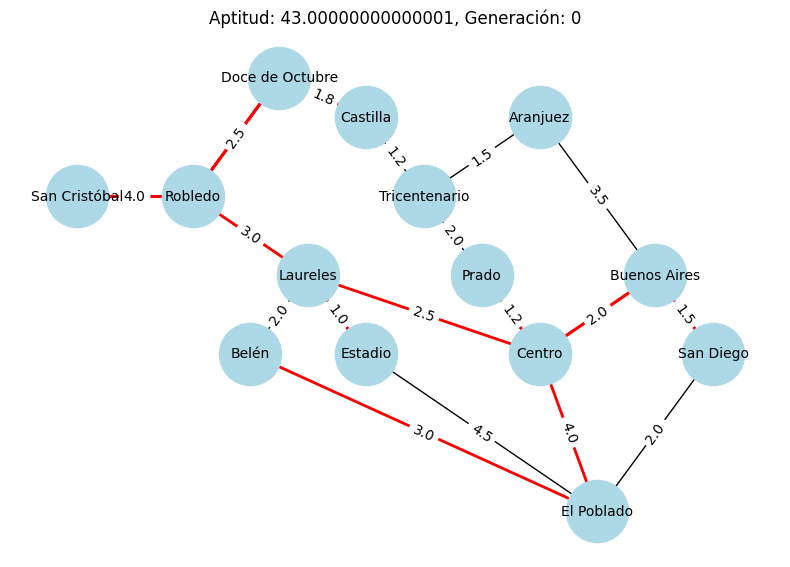

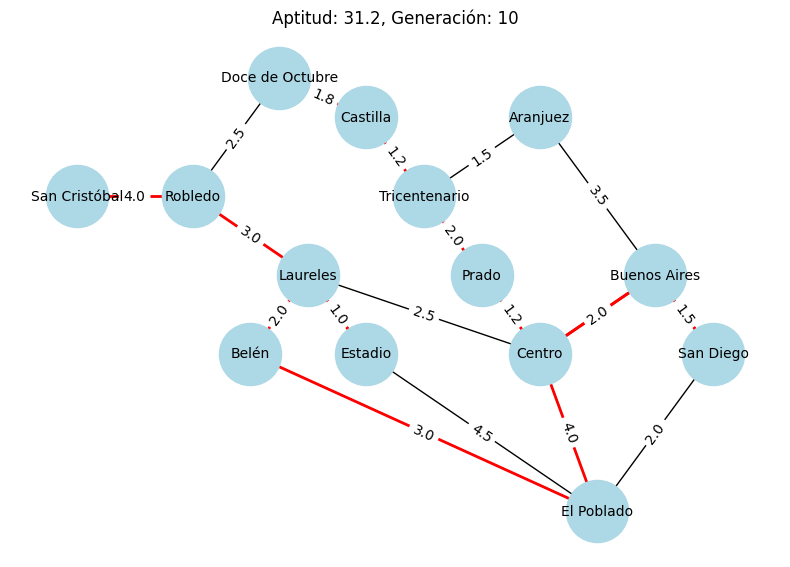

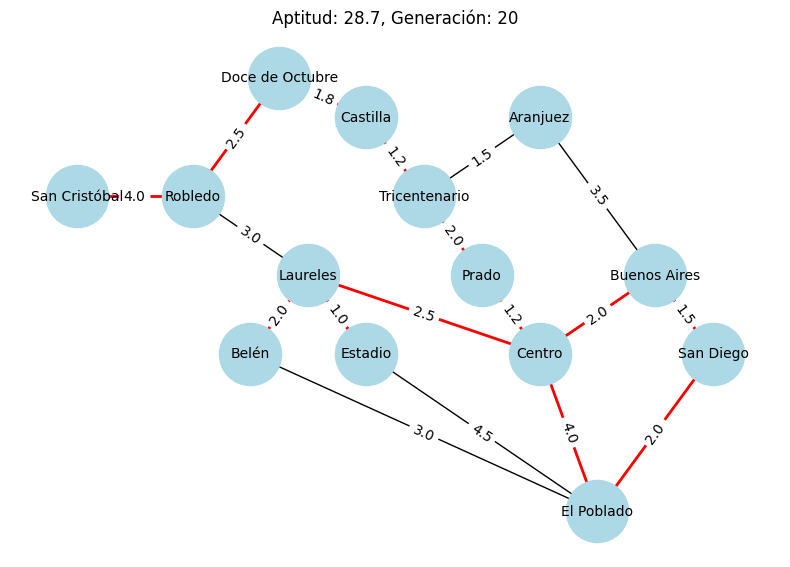

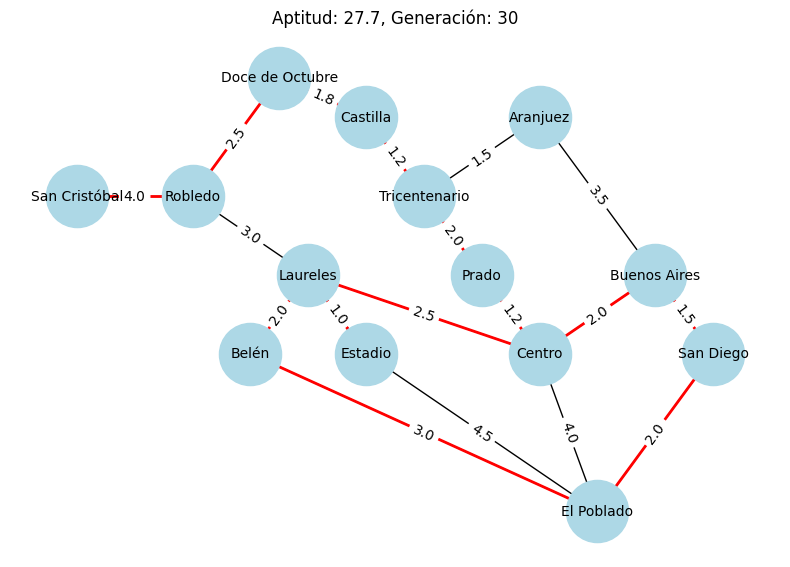

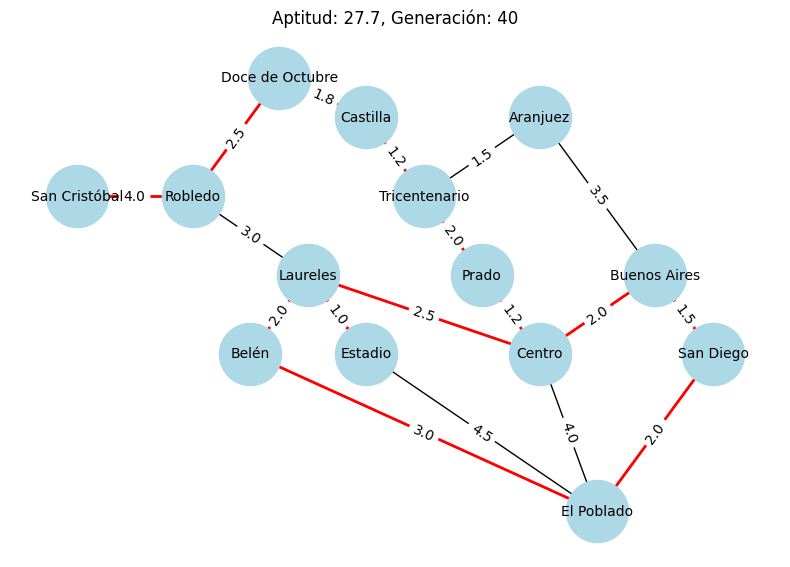

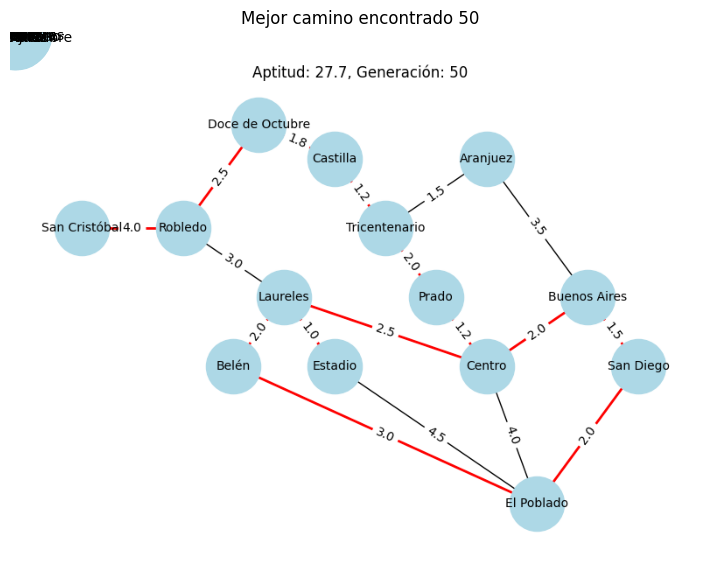

In [29]:
goals = list(GRAPH.keys())
num_selected = random.randint(2, len(goals))
goals = random.sample(goals, num_selected)
print(f"Nodos objetivo seleccionados: {goals}")
print()

pop_size = 100
generations = 50
snapshots = 10

best_route, full_path, best_fitness = route_GA(GRAPH, goals, population_size=pop_size, generations=generations, snapshots=snapshots)

print(f"Mejor orden encontrado: {best_route}")

print(f"Camino completo: ")
for element in full_path:
    print(f"  {element} ->", end=" ")
print()

img = mpimg.imread(f"../img/generation_{generations}.png")
plt.imshow(img)
plt.axis('off')
plt.title(f"Mejor camino encontrado {generations}")
plt.show()
plt.close()